Author: Nicolas Legrand <nicolas.legrand@cas.au.dk>

In [1]:
from pathlib import Path
import pandas as pd
import json
import itertools
from qwen_math_parser import extract_answer, strip_string
from grader import math_equal
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
result_df = pd.DataFrame([])

In [3]:
dataset = "math500r"
model_id = "Qwen/Qwen2.5-3B-Instruct"

In [4]:
result_path = Path.cwd().parent / "results" / model_id / dataset / "forward-pass" / "1"
for file_path in tqdm(result_path.glob("*.json")):
    # load JSON files
    with open(file_path, "r") as f:
        data = json.load(f)

    model_response = data["model_response_0"]
    answer = strip_string(data["expected_answer"])
    model_output = extract_answer(model_response, data_name=dataset)
    accuracy = math_equal(model_output, answer)

    result_df = pd.concat(
        [
            result_df,
            pd.DataFrame(
                {
                    "method": "early-stop",
                    "model_id": model_id,
                    "dataset": dataset,
                    "n_samples": 1,
                    "n_sampling_steps": 0,
                    "file_path": file_path.name,
                    "expected_answer": answer,
                    "model_output": model_output,
                    "accuracy": accuracy,
                    "n_question": data["n_question"],
                    "n_reasoning_steps": [1],
                },
                index=[0],
            ),
        ],
        ignore_index=True,
    )

99it [00:00, 200.08it/s]


In [5]:
result_path = Path.cwd().parent / "results" / model_id / dataset / "early-stop" / "16"
for n_sampling_steps in ["1", "2", "5", "40"]:
    path = result_path / n_sampling_steps
    for file_path in tqdm(path.glob("*.json")):
        # load JSON files
        with open(file_path, "r") as f:
            data = json.load(f)

        model_response = data["model_response"]
        answer = strip_string(data["expected_answer"])
        model_output = extract_answer(model_response, data_name=dataset)
        accuracy = math_equal(model_output, answer)

        result_df = pd.concat(
            [
                result_df,
                pd.DataFrame(
                    {
                        "method": "early-stop",
                        "model_id": model_id,
                        "dataset": dataset,
                        "n_samples": 16,
                        "n_sampling_steps": n_sampling_steps,
                        "file_path": file_path.name,
                        "expected_answer": answer,
                        "model_output": model_output,
                        "accuracy": accuracy,
                        "n_question": data["n_question"],
                        "n_reasoning_steps": [1],
                    },
                    index=[0],
                ),
            ],
            ignore_index=True,
        )

99it [00:00, 345.77it/s]
99it [00:00, 277.28it/s]
99it [00:00, 335.16it/s]
99it [00:00, 282.16it/s]


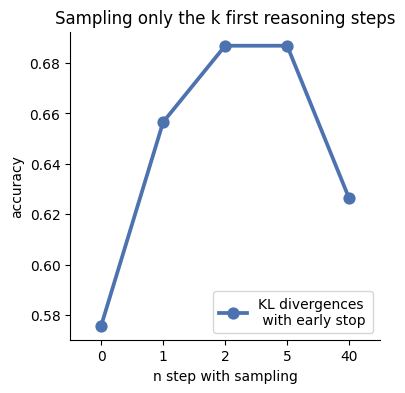

In [6]:
fig, ax = plt.subplots(figsize=(4, 4), sharey=True)
sns.pointplot(
    x="n_sampling_steps",
    y="accuracy",
    color="#4c72b0",
    errorbar=None,
    data=result_df,
    ax=ax,
    label="KL divergences \n with early stop",
)
sns.despine()
ax.set(title="Sampling only the k first reasoning steps", xlabel="n step with sampling")
plt.savefig(
    Path.cwd().parent / "figures" / "appendix_1.pdf", bbox_inches="tight", dpi=300
)